## XGBoostのサンプルコード

In [1]:
# ライブラリーのインポート
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# XGBoost
import xgboost as xgb

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
print(xgb.__version__)

1.2.0


In [3]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns = boston.feature_names)
# 目的変数の追加
df['MEDV'] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [4]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0:df.shape[1]-1],
                                                    df.iloc[:, df.shape[1]-1],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train,
                                                      test_size=TEST_SIZE,
                                                      random_state=RANDOM_STATE)

# XGBoostを利用するのに必要なフォーマットに変換
xgb_train = xgb.DMatrix(x_train, label=y_train, feature_names=boston.feature_names)
xgb_eval = xgb.DMatrix(x_valid, label=y_valid, feature_names=boston.feature_names)
xgb_test = xgb.DMatrix(x_test, label=y_test, feature_names=boston.feature_names)

In [5]:
# XGBoostのパラメータ設定
params = {
    'boosting_type': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.03,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'vervose': 0
}

In [6]:
# XGBoost学習

# 学習の経過を保存する箱
evaluation_results = {}
evals = [(xgb_train, 'train'), (xgb_eval, 'eval')]
model = xgb.train(params,
                  xgb_train,
                  num_boost_round=500,
                  evals=evals,
                  evals_result=evaluation_results,
                  early_stopping_rounds=50,
                 )

[07:01:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { boosting_type, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:22.67278	eval-rmse:21.37412
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:22.03252	eval-rmse:20.76652
[2]	train-rmse:21.41239	eval-rmse:20.16382
[3]	train-rmse:20.81001	eval-rmse:19.59341
[4]	train-rmse:20.22535	eval-rmse:19.03268
[5]	train-rmse:19.65824	eval-rmse:18.50662
[6]	train-rmse:19.10829	eval-rmse:17.98572
[7]	train-rmse:18.57115	eval-rmse:17.47343
[8]	train-rmse:18.05022	eval-rmse:16.98158
[9]	train-rmse:17.54435	eval-rmse:16.50185
[10]	train-rmse:17

In [7]:
# XGBoost推論
y_pred = model.predict(xgb_test, ntree_limit=model.best_ntree_limit)

In [8]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

In [9]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE      RMSE
scores  0.885371  2.606647  11.987953  3.462362


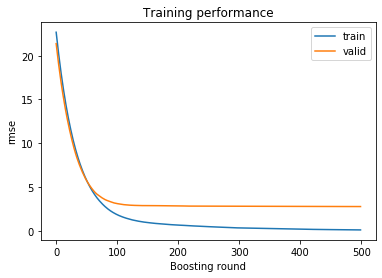

In [10]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['rmse'], label='train')
plt.plot(evaluation_results['eval']['rmse'], label='valid')
plt.ylabel('rmse')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()